# Source Detection and Measurement

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>Contact authors: Douglas Tucker, Alex Drlica-Wagner<br>
Last verified to run: 2025-03-06 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container Size: medium <br>
Targeted learning level: Intermediate <br>

**Description:** Access, display, and manipulate images; detect, deblend, and measure sources; and extract, plot, and use object footprints.

**Skills:** Run source detection, deblending, and measurement. Use source footprints.

**LSST Data Products:** DP0.2 processed visit images and catalogs.

**Packages:** lsst.pipe.tasks.characterizeImage, lsst.meas.algorithms.detection.SourceDetectionTask, lsst.meas.deblender.SourceDeblendTask, lsst.meas.base.SingleFrameMeasurementTask, lsst.meas.base.ForcedMeasurementTask

**Credit:**
Originally developed by Alex Drlica-Wagner and Imran Hasan in the context of the LSST Stack Club.
Forced photometry routine by Tobias Géron and Melissa Graham 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides a brief introduction to running the LSST Science Pipelines source detection, deblending, and measurement tasks.
It does not go into depth about optimizing these tasks for different types of sources.
It also covers how to access the footprint of a detected source and how to do forced photometry at user-specified coordinates.

Some source detection and measurement details come from Robert Lupton's [Tune Detection.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Tune%20Detection.ipynb) and [Kron.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Kron.ipynb).
Interaction with `lsst.afw.display` was also improved by studying Michael Wood-Vasey's [DC2_Postage Stamps.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_postage_stamps.ipynb).
More information on footprints can be found in [this Stack Club notebook by Imran Hasan](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb).

### 1.1. Import packages

The [`numpy`](https://numpy.org/) and [`matplotlib`](https://matplotlib.org/) are widely used Python plot libraries.

From the [LSST Science Pipelines](https://pipelines.lsst.io/), modules for data access via the butler, image display,
image geometry, table handling, and various tasks for image characterization and source detection, deblending,
and measurement are imported.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getpass

import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask

### 1.2. Define functions and parameters

Set `afwDisplay` to use `Firefly` as its backend.

Set `afw_display` to be frame 1.

Firefly should have opened in a new tab in the same workspace area as this notebook.

Click on the "Firefly: stateClient..." tab and drag it down and to the right of this workspace in order to work with the notebook and Firefly side-by-side.

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Set the `matplotlib` plot color table to be colorblind-friendly.

In [ ]:
plt.style.use('tableau-colorblind10')

Instantiate butler access to the DP0.2 data sets.

In [ ]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

## 2. Image access, display, and manipulation


### 2.1. Retrieve and display a `calexp`

Define the `dataId` for pre-selected visit 512055 and detector 75,
then use the `butler` to retrieve the `calexp` (processed visit image).

In [ ]:
dataId = {'visit': 512055, 'detector': 75}

In [ ]:
calexp = butler.get('calexp', dataId=dataId)

A `calexp` contains the image plus a mask and variance planes.

**Option:** uncomment any of the following lines and execute the following cell to learn more about the various aspects of the `calexp`.

In [ ]:
# calexp.maskedImage
# calexp.maskedImage.image
# calexp.maskedImage.mask
# calexp.maskedImage.variance
# calexp.image
# calexp.mask
# calexp.variance

The retrieved `calexp` also contains the point-spread function (PSF), the world coordinate system (WCS),
and the photometric calibration for the image.

These components could be retreived with the following statements.
```
psf = calexp.getPsf()
wcs = calexp.getWcs()
pcal = calexp.getPhotoCalib()
```

Display the `calexp` image and set the mask layer to be 100% transparent,
so that the display shows only the image (i.e., does not color the pixels by mask value).

In [ ]:
afw_display.mtv(calexp)
afw_display.setMaskTransparency(100)

### 2.2. Add the sky background back into the image

As an example of how to manipulate an image before reprocessing, use the `butler` to
retrieve the sky background which was subtracted, and add it back in to the image.

In [ ]:
bkgd = butler.get('calexpBackground', dataId=dataId)

Reset `afw_display` to be for frame 2, and display the background.

In [ ]:
afw_display = afwDisplay.Display(frame=2)
afw_display.mtv(bkgd.getImage())

Add the background into the `calexp` and display the results.

**Warning!** Only execute this cell once or the background will be re-added multiple times.

In [ ]:
calexp.maskedImage += bkgd.getImage()

Reset `afw_display` to be for frame 3, display the `calexp`,
and set mask transparency to 100%.

In [ ]:
afw_display = afwDisplay.Display(frame=3)
afw_display.mtv(calexp)
afw_display.setMaskTransparency(100)

<div style="max-width:500px;margin-right: auto; margin-right: 0;">

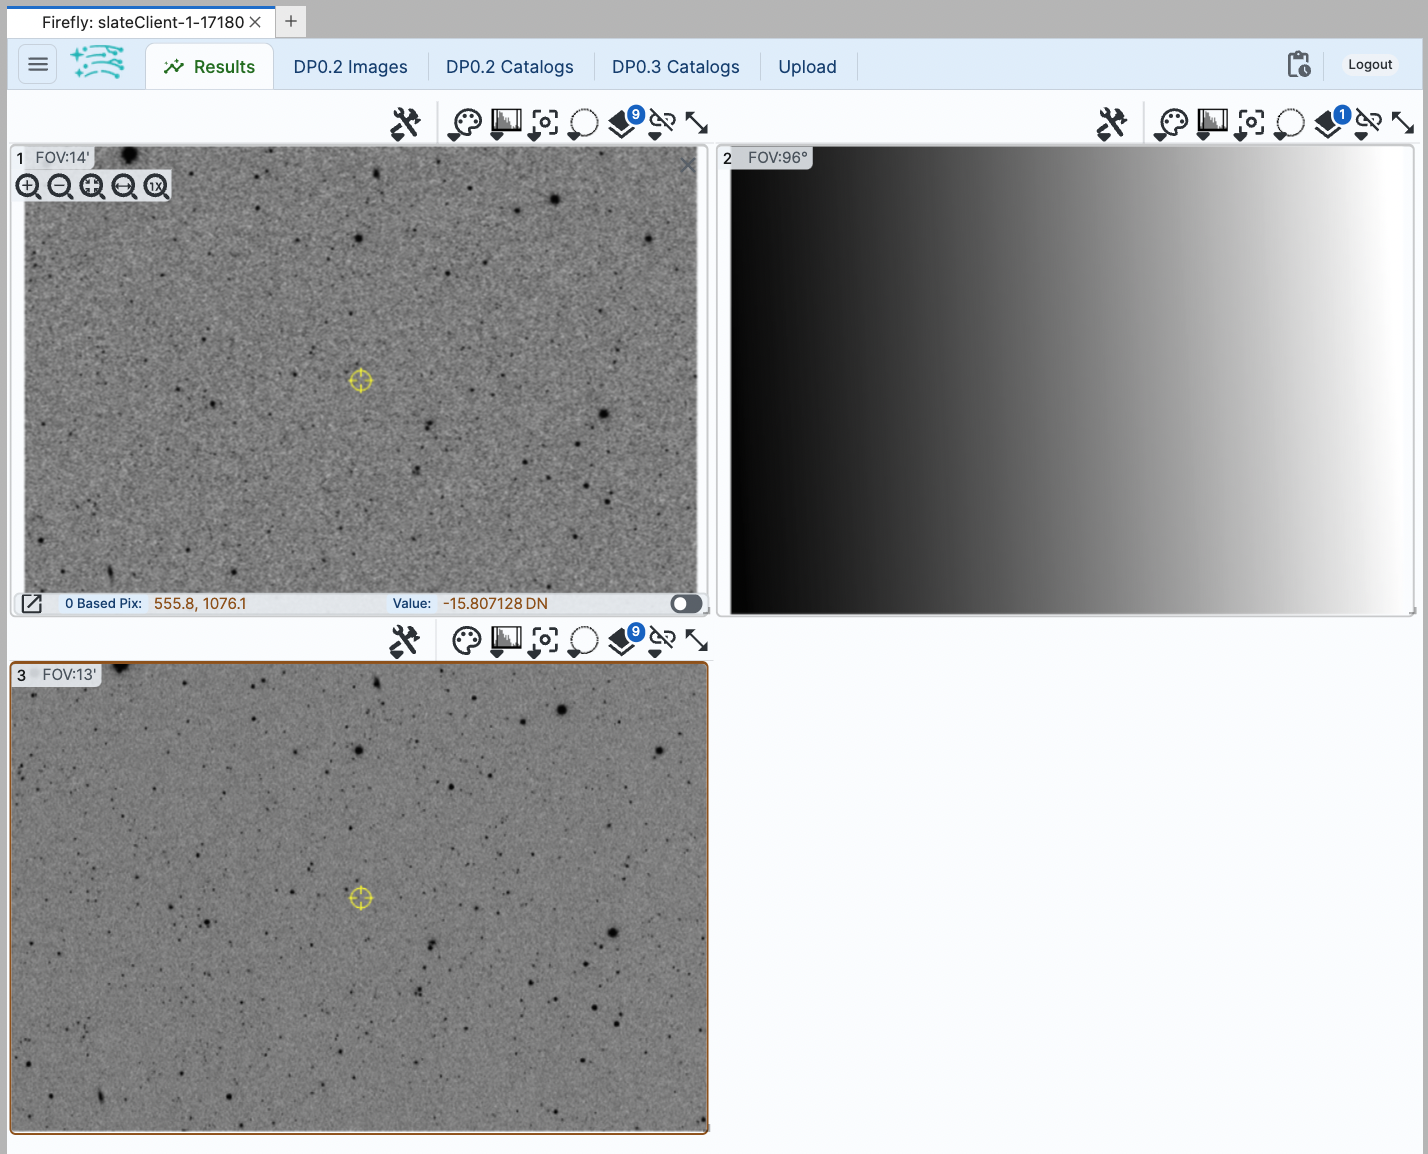

</div>

> Figure 1: A screenshot of what the Firefly interface should look like with the original `calexp` (upper left), the background image (upper right), and the `calexp` with the background added back in (lower left) all displayed in frames 1 through 3, respectively.

**If images are displayed side-by-side instead of tiled**,
as in the screenshot above,
find the "Scroll Images" toggle at upper left in the Firefly window and click it.

Compare the pixel values of the original `calexp` in frame 1 and the
new `calexp` with background in frame 3.

**Action:** 
With the mouse, hover over any image in the Firefly window and see the coordinates
and pixel value for the mouse position appear at the bottom of the image.

If the pixel value does not appear, only coordinates, there are two main options.

1. Expand the size of the Firefly window by clicking and dragging the grey vertical line between tutorial notebook and Firefly window until "Value" appears to the right of "EQ-J2000".

2. Click on the "Show expanded readout" icon in the lower-left corner (a box with an arrow pointed at the upper-right corner). A pop-up window will open which contains the pixel value at the bottom.

Now with the mouse, hover over the images in frames 1, 2, and 3 and see how the pixel values differ by the value of the background pixels.

Reset the Firefly window size or close the pop-up window.

**Action:** Close each frame by clicking on the X in the upper-right corner of the image (it is not very visible until the mouse is over it). The Firefly interface should now say "Firefly Ready".

Clean up. Do not use the `calexp` + `bkgd` in the sections below. A fresh version of the `calexp` is retrieved in Section 3.1.2.

In [ ]:
del calexp, bkgd

## 3. Source detection, deblending, and measurement

The LSST Science Pipelines' source detection, deblending, and measurement tasks were imported in the first code cell.

More information can be found at [pipelines.lsst.io](https://pipelines.lsst.io/), either by scrolling down and
browsing the available modules or by using the search bar at upper left.

The schema describes the output properties that will be measured for each source.
The schema needs to be passed to all of the tasks, each of which will add columns to it when it runs.

Create a minimal schema for a source table.

In [ ]:
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

Add `coord_raErr` and `coord_decErr` to the minimal schema to avoid warnings 
from `sourceMeasurementTask` in Section 3.4, which expects these columns to exist.

In [ ]:
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")

Create a container which will be used to record metadata about algorithm execution.

In [ ]:
algMetadata = dafBase.PropertyList()

### 3.1. Configure the tasks

Each task possesses an associated configuration class. The properties of these configuration classes can be determined from the classes themselves.

**Option:** uncomment the following line to view the help documentation for the `CharacterizeImageTask` configuration.
Replace `CharacterizeImageTask` with another task name to view its help documentation.

In [ ]:
# help(CharacterizeImageTask.ConfigClass())

In [ ]:
# help(SourceDetectionTask.ConfigClass())

Set the basic configuration parameters and instantiate each task in turn.

`CharacterizeImageTask` characterizes the image properties (e.g., the PSF).

Set the configuration to only do one PSF iteration.

In [ ]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)
del config

`SourceDetectionTask` detects sources.

Set the configuration for the detection threshold to 4 (the default for LSST catalogs is 5) in order to detect sub-threshold (faint) sources.
Set the detection threshold type to be `stdev`, which means the threshold is applied to the image's standard deviation.
In other words, this configuration will detect sources at $4\sigma$.

In [ ]:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 4
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
del config

`SourceDeblendTask` deblends overlapping sources into "parent" and "child" sources.
No configuration is needed for this tutorial.

In [ ]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

`SingleFrameMeasurementTask` measures the properties of the deblended sources. No special configuration is needed for this tutorial.

In [ ]:
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)
del config

Create a `SourceTable` called `tab` using the minimal schema. It will hold the output of the analysis in the following section.

Then, as `schema` is no longer needed and a fresh minimal schema is made in Section 5, delete this one.

In [ ]:
tab = afwTable.SourceTable.make(schema)
del schema

#### 3.1.1. Re-configure tasks and explore methods

The configuration parameters cannot be changed after the task is constructed.
To change a configuration parameter, redefine it and then also redefine the task.

For example, to change the number of PSF iterations done during image characterization:
```
config.psfIterations = 3
charImageTask = CharacterizeImageTask(config=config)
```

**Option:** To explore a task, use the `help` function on the task or any of its methods.

In [ ]:
# help(charImageTask)

In [ ]:
# help(charImageTask.writeSchemas)

**Option:** To see a pop-up list of all methods for a given task, uncomment this line, place the cursor after the period, and press tab.
Then re-comment the line. Do not execute the cell.

In [ ]:
# charImageTask.

#### 3.1.2. Retrieve a fresh version of the image

Retrieve a fresh, unaltered `calexp` image from the butler.

In [ ]:
calexp = butler.get('calexp', dataId=dataId)

Clear the "DETECTED" information from the mask plane, as source detection
is going to be re-done below.

In [ ]:
calexp.mask.removeAndClearMaskPlane('DETECTED')

### 3.2. Image characterization

Characterize the `calexp` image. This calculates various global properties of the image, such as the PSF FWHM (full-width half-max).

In [ ]:
result = charImageTask.run(calexp)

The `result` is a structure, [`lsst.pipe.base.struct.Struct`](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1pipe_1_1base_1_1struct_1_1_struct.html).

A `Struct` is just a generalized container for storing multiple output components and accessing them as attributes.

In [ ]:
type(result)

The content of this `Struct` can be investigated with the `getDict` method.

In [ ]:
for k, v in result.getDict().items():
    print(k, type(v))

**Option:** the `Struct` can be displayed but this is not very useful.

In [ ]:
# result

As an example of how to interact with the results of image characterization, get the PSF at a specific
pixel location and print the FWHM. The factor of 2.355 converts from the standard deviation to the FWHM.

In [ ]:
x, y = 1700, 2100
point = geom.Point2D(x, y)
psf = calexp.getPsf()
sigma = psf.computeShape(point).getDeterminantRadius()
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
print('PSF FWHM = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

del x, y, point, psf, sigma, pixelScale

### 3.3. Source detection

Run source detection.

In [ ]:
result = sourceDetectionTask.run(tab, calexp)

Print the number of positive peaks detected.

In [ ]:
result.numPosPeaks

With `thresholdValue` set to 4, over 2000 sources are detected.

Had the `thresholdValue` been set instead to 10, there would have been about 940 peaks detected.

Create `sources` to hold the detected sources from the results.

In [ ]:
sources = result.sources

**Option:** Display `sources` to see that most of the columns are `NaN` at first.

In [ ]:
# sources

**Option:** Write the `sources` to a FITS table, or save the `calexp` as a FITS file, in the home directory.

In [ ]:
# home_directory = '/home/' + getpass.getuser() + '/'
# sources.writeFits(home_directory + "DP02_NB05_sources.fits")
# calexp.writeFits(home_directory + "DP02_NB05_calexp.fits")

### 3.4. Source debelending and measurement

Run the `SourceDeblendTask` and `SingleFrameMeasurementTask`.

In [ ]:
sourceDeblendTask.run(calexp, sources)

In [ ]:
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

Ensure that the `sources` catalog is contiguous (sequential) in memory by making a copy.

In [ ]:
sources = sources.copy(True)

**Option:** Display the `sources` catalog as an `astropy` table, which has a nice, human-readable output format.

In [ ]:
# sources.asAstropy()

### 3.5. Visualize sources on an image cutout

Overplot the detected sources on a cutout image of the `calexp` using `afwDisplay`.

There are several ways to create image cutouts. This tutorial demonstrates the use of the `Factory` method for a `calexp`.

The arguments that must be passed to the `Factory` method are:
```
calexp : the ExposureF to make the cutout from
bbox   : the desired bounding box of the cutout
origin : the image pixel origin, local to the cutout array
deep   : if True, copy the data rather than passing by reference
```

Define the `bbox` region for a cutout that is centered on pixel coordinate 1700, 2100 and is 400 pixels wide and 400 pixels high.

In [ ]:
x, y = 1700, 2100
w, h = 400, 400
xmin, ymin = x - w//2, y - h//2
print(xmin, ymin)
bbox = geom.Box2I()
bbox.include(geom.Point2I(xmin, ymin))
bbox.include(geom.Point2I(xmin + w, ymin + h))
del x, y, w, h, xmin, ymin

**Option:** Display the `bbox` information.

In [ ]:
# bbox

An alternative statement to create `bbox` is:
```
bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(w, h))
```

Generate the cutout.

In [ ]:
cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)

Reset `afw_display` to be for frame 1, display the cutout, and
set mask transparency to 100%.

In [ ]:
afw_display = afwDisplay.Display(frame=1)
afw_display.mtv(cutout)
afw_display.setMaskTransparency(100)

If frame 1 only fills half of the Firefly interface, click and drag the lower right corner to resize frame 1.

Overplot sources as orange circles.
Use display buffering while overplotting sources to avoid re-drawing the image after each source is plotted.

In [ ]:
with afw_display.Buffering():
    for s in sources:
        x = s.getX()
        y = s.getY()
        if (x > 1500) & (x < 1900) & (y > 1900) & (y < 2300):
            afw_display.dot('o', x, y, size=20, ctype='orange')
        del x, y

<div style="max-width:300px;margin-right: auto; margin-right: 0;">

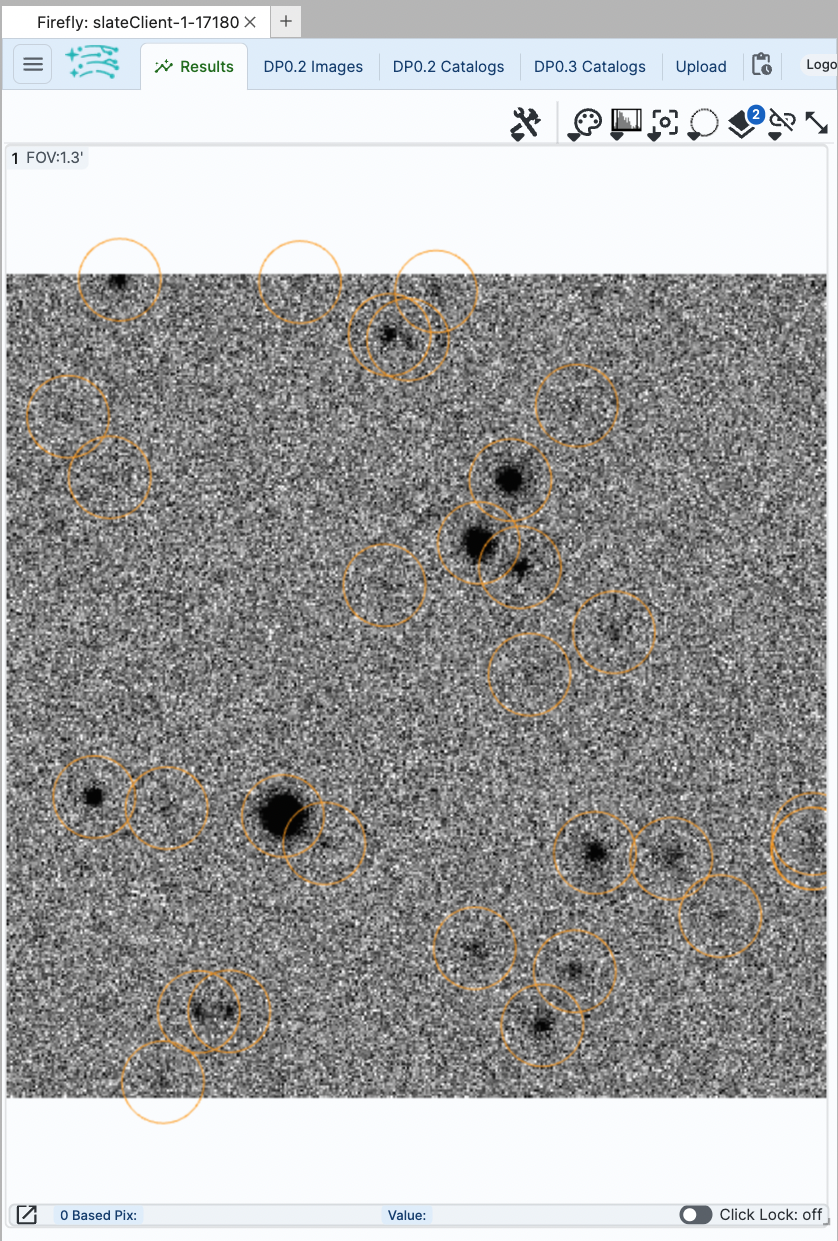

</div>

> Figure 2: A screenshot of what the Firefly interface should look like with the cutout displayed and detected sources overplotted with orange circles.

Clean up. Keep `sources` and `result` for the next sections.

In [ ]:
del bbox, cutout, tab

## 4. Footprints

Object footprints are an integral component of the high-level CCD processing tasks (e.g., detection, measurement, and deblending).

To quote [Bosch et al. (2017)](https://arxiv.org/pdf/1705.06766.pdf): *"Footprints record the exact above-threshold detection region on a CCD. These are similar to  SExtractor’s “segmentation map", in that they identify which pixels belong to which detected objects."*

This quote draws an analogy between footprints and segmentation maps because they both identify pixels with values above some threshold.

The result of the `SourceDetectionTask` stores the footprints associated with detected objects.

Grab the above-threshold footprints that were detected, and assign them to the variable `fps`.

In [ ]:
fpset = result.positive
fps = fpset.getFootprints()

Get a rough view of the first source's footprint from its span.

In [ ]:
fps[0].getSpans()

Above, the footprint is represented by the 1s in the array.

Note that the first row of the span array will be the *bottom* row of the image, and so is "upside down" compared to the heavy footprint visualization below.

### 4.1. Heavy Footprints

The footprint span above indicates which pixels are included in the footprint (the 1s).

A heavy fooprint includes the pixel value data from the image.

Demonstrate that the `fps` footprint is not heavy.

In [ ]:
fps[0].isHeavy()

Make all of the footprints heavy and define `hfps` to hold the heavy footprints.

In [ ]:
fpset.makeHeavy(calexp.getMaskedImage())
hfps = fpset.getFootprints()

The `getImageArray` method returns a flattened, 1-dimensional array of pxiels from the footprint.

**Option:** Uncomment the line below to print the array and see that it contains pixel values.

In [ ]:
# hfps[0].getImageArray()

Use the span's method to unflatten the image array, and display the heavy footprint ([matplotlib colormap options](https://matplotlib.org/stable/tutorials/colors/colormaps.html)).

In [ ]:
fig = plt.figure()
plt.imshow(fps[0].getSpans().unflatten(hfps[0].getImageArray()),
           cmap='bone', origin='lower')
plt.show()

> Figure 3: The heavy footprint of the first source in the `result` array from `SourceDetectionTask`.

The heavy footprint also comes with a 1-dimensional mask array.

**Option:** Display the 1-d mask array.

In [ ]:
# hfps[0].getMaskArray()

Review the dictionary for the mask plane, which maps mask value to the reason the pixel is masked.

In [ ]:
calexp.getMask().getMaskPlaneDict()

The values are the exponent of the bitmask.

Pixels only marked detected will be 2^5 = 32.

Pixels that are both on the edge of the original image and detected will be 2^5 + 2^4 = 48.

Visualize mask array.

To show the colorbar, create a new axis `cax` on the right side of the image display,
with a width of 5% and a padding between display and colorbar of 1%.
Add ticks to the colorbar at values of 32 and 48, to correspond to the two
mask values of interest ("detected" and "detected + edge").

In [ ]:
plt.figure()
im = plt.imshow(fps[0].getSpans().unflatten(hfps[0].getMaskArray()),
                origin='lower')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="1%")
plt.colorbar(im, cax=cax, ticks=[0, 32, 32+16])
plt.show()

> Figure 4: Above, the footprint's mask array reveals which pixels are considered (green) but which are also at the edge of the `calexp` (yellow).

Clean up.

In [ ]:
del fpset, fps, hfps

## 5. Forced photometry

The LSST Science Pipelines have a task for <a href="https://pipelines.lsst.io/modules/lsst.meas.base/tasks_and_algorithms.html#forced-photometry">forced photometry</a>, called `ForcedMeasurementTask`.

This task will use the PSF of the image to measure flux at any user-supplied coordinates.
As it is not a *fit*, a flux is returned whether an astronomical source is there or not.
Forced photometry can be very useful for including sources below the detection
threshold (or non-detections) in analyses.

### 5.1. Configure the task

To start, create a minimal schema.

In [ ]:
schema = afwTable.SourceTable.makeMinimalSchema()

At this time, the `ForcedMeasurementTask` expects a few additional columns related to the centroids
and shapes to pre-exist, so add them to the minimal schema.
These might change in the future.

In [ ]:
alias = schema.getAliasMap() 
x_key = schema.addField("centroid_x", type="D")
y_key = schema.addField("centroid_y", type="D")
alias.set("slot_Centroid", "centroid")

xx_key = schema.addField("shape_xx", type="D")
yy_key = schema.addField("shape_yy", type="D")
xy_key = schema.addField("shape_xy", type="D")
alias.set("slot_Shape", "shape")

Add a type flag, which will be 0 for sub-threshold (faint) sources and 1 for random "off-source" coordinates.

In [ ]:
type_key = schema.addField("type_flag", type="F")

Create an empty `forcedSource` catalog using the schema. It will have 0 rows, to start.

In [ ]:
forcedSource = afwTable.SourceCatalog(schema)
print(len(forcedSource))

Configure the `ForcedMeasurementTask`. At this time, few plugins beyond the default are required, as is the `doReplaceWithNoise` configuration. These might change in the future.

In [ ]:
config = ForcedMeasurementTask.ConfigClass()
config.copyColumns = {}
config.plugins.names = [
    "base_TransformedCentroid",
    "base_PsfFlux",
    "base_TransformedShape"
]
config.doReplaceWithNoise = False

Define the task using the schema and configuration.

In [ ]:
forcedMeasurementTask = ForcedMeasurementTask(schema, config=config)
del config

### 5.2. Define the coordinates

Scientific motivations for forced photometry include measurement of sub-threshold (faint) sources or a 
need for an upper-limit on the flux of a time-varying source.

The potential drawback of forced photometry is that all the flux within the area of the PSF is included,
which means nearby sources can contaminate (add excess flux to) the forced photometry.
This will be demonstrated in Section 5.4.

For this example, create a list of sub-threshold (faint) coordinates and random "off-source" coordinates which are not near any detected sources.
Use a region within 2 arcmin of the center of the field.

#### 5.2.1. Sub-threshold (faint) sources

Create `numpy` arras of the right ascension and declination, x- and y-pixel coordinates, and instrumental flux and its error
from the list of detected sources. Calculate the signal-to-noise ratio.

In [ ]:
srcs_ra = np.asarray(np.rad2deg(sources['coord_ra']), dtype='float')
srcs_dec = np.asarray(np.rad2deg(sources['coord_dec']), dtype='float')
srcs_xpix = np.asarray(sources['base_SdssCentroid_x'], dtype='float')
srcs_ypix = np.asarray(sources['base_SdssCentroid_y'], dtype='float')
srcs_flux = np.asarray(sources['base_PsfFlux_instFlux'], dtype='float')
srcs_fluxe = np.asarray(sources['base_PsfFlux_instFluxErr'], dtype='float')
srcs_snr = srcs_flux/srcs_fluxe

Use the `bbox` and `wcs` to get the central coordinates of the `calexp`, convert from pixels to sky coordinates,
and calculate offsets (`s_dra` and `s_ddec`) between the sources and the image center.

In [ ]:
bbox = calexp.getBBox()
wcs = calexp.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerX)
cra = center.getRa().asDegrees()
cdec = center.getDec().asDegrees()
srcs_dra = np.abs(srcs_ra - cra)
srcs_ddec = np.abs(srcs_dec - cdec)

Define the maximum offset from the image center to be 2 arcminutes (in units of degrees).

Find all sources with 4 $<$ SNR $<$ 5 (i.e., sub-threshold sources) within the central region.

Define new arrays to hold only the information of the sources to be used for forced photometry, and clean up.

In [ ]:
dmax = 2.0 / 60.0
tx = np.where((srcs_snr > 4) & (srcs_snr < 5)
              & (srcs_dra < dmax) & (srcs_ddec < dmax))[0]
print(len(tx))

s_ra = srcs_ra[tx]
s_dec = srcs_dec[tx]
s_xpix = srcs_xpix[tx]
s_ypix = srcs_ypix[tx]
s_flux = srcs_flux[tx]

del tx, dmax
del srcs_ra, srcs_dec, srcs_xpix, srcs_ypix, srcs_flux, srcs_fluxe, srcs_snr
del srcs_dra, srcs_ddec

Add the coordinates of these 32 sub-threshold sources to the `forcedSource` catalog.

Sky coordinates must be in radians.

In [ ]:
for i in range(len(s_ra)):
    sourceRec = forcedSource.addNew()
    coord = geom.SpherePoint(np.radians(s_ra[i]) * geom.radians,
                             np.radians(s_dec[i]) * geom.radians)
    sourceRec.setCoord(coord)
    sourceRec[x_key] = s_xpix[i]
    sourceRec[y_key] = s_ypix[i]
    sourceRec[type_key] = 0
    del sourceRec, coord

print(len(forcedSource))

#### 5.2.2. Random "off-source" coordinates

Create 32 random coordinates in the central region of the image. Ensure they are offset by at least 40 pixels from the nearest detected source.

In [ ]:
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
radius_pix = int(2.0 * 60.0 / pixelScale)
center_x = bbox.centerX
center_y = bbox.centerY

tempx = []
tempy = []
while len(tempx) < 32:
    r = np.random.choice(radius_pix)
    theta = np.random.rand() * 2 * np.pi
    x = center_x + r * np.cos(theta)
    y = center_y + r * np.sin(theta)
    off = np.min(np.sqrt((x - s_xpix)**2 + (y - s_ypix)**2))
    if off > 40:
        tempx.append(x)
        tempy.append(y)
    del r, theta, x, y, off

r_xpix = np.asarray(tempx)
r_ypix = np.asarray(tempy)
del pixelScale, radius_pix, center_x, center_y, tempx, tempy

Use the image's WCS to convert the random pixels to sky coordinates.

In [ ]:
r_ra = np.zeros(len(r_xpix), dtype='float')
r_dec = np.zeros(len(r_ypix), dtype='float')
for i in range(len(r_xpix)):
    r_skycoord = wcs.pixelToSky(r_xpix[i], r_ypix[i])
    r_ra[i] = r_skycoord.getRa().asDegrees()
    r_dec[i] = r_skycoord.getDec().asDegrees()
    del r_skycoord

Add the random "off-source" coordinates to the `forcedSource` catalog.

In [ ]:
for i in range(len(r_xpix)):
    sourceRec = forcedSource.addNew()
    coord = geom.SpherePoint(np.radians(r_ra[i]) * geom.radians,
                             np.radians(r_dec[i]) * geom.radians)
    sourceRec.setCoord(coord)
    sourceRec[x_key] = r_xpix[i]
    sourceRec[y_key] = r_ypix[i]
    sourceRec[type_key] = 1
    del sourceRec, coord

print(len(forcedSource))

**Option:** View the `forcedSource` table.

In [ ]:
# forcedSource

### 5.3. Run the task

Create an empty catalog to store forced measurements.

In [ ]:
forcedMeasCat = forcedMeasurementTask.generateMeasCat(calexp, forcedSource,
                                                      calexp.getWcs())

Option to review the `forcedMeasCat`.
Before the task is run, all the columns are empty (or default values).

In [ ]:
# forcedMeasCat

Run the forced measurements.

In [ ]:
forcedMeasurementTask.run(forcedMeasCat, calexp, forcedSource, calexp.getWcs())

### 5.4. Explore the results

Get the results as an `astropy` table.

In [ ]:
table = forcedMeasCat.asAstropy()

Add the `type_flag` column from `forcedSource` to `table`.

In [ ]:
temp = forcedSource.asAstropy()
table['type_flag'] = temp['type_flag']
del temp

**Option:** View the filled `forcedMeasCat` results as the `astropy` table.

In [ ]:
# table

Display the full `calexp` in frame 1.

In [ ]:
afw_display = afwDisplay.Display(frame=1)
afw_display.mtv(calexp)
afw_display.setMaskTransparency(100)

Overplot the coordinates used for forced photometry on the image.

Use circles to mark sub-threshold (faint) source coodinates (orange) and random "off-source" coordinates (cyan), showing the locations where forced photometry was done.

In [ ]:
with afw_display.Buffering():
    for i in range(len(table)):
        clr = 'orange'
        if table['type_flag'][i] == 1:
            clr = 'cyan'
        afw_display.dot('o', table['slot_Centroid_x'][i],
                        table['slot_Centroid_y'][i],
                        size=20, ctype=clr)

Zoom-in on the displayed image in Firefly to further explore the
locations where forced photometry was performed.

Compare the forced photometry fluxes with the measured fluxes for sub-threshold (faint) sources.

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot([2500, 3000], [2500, 3000], lw=0.5, color='black')
for i in range(32):
    plt.plot(s_flux[i], table['base_PsfFlux_instFlux'][i],
             'o', color='darkorange', mew=0, alpha=0.5)
plt.xlabel('detection flux')
plt.ylabel('forced PSF flux')
plt.show()

> Figure 5: Above, the original detection instrumental flux (in counts) versus the forced PSF flux measurements for the 32 sources which were originally detected with 4 $<$ SNR $<$ 5. For most sources the fluxes agree, but in some cases the forced PSF flux is greater.

Cases in which the forced PSF flux is greater is likely due to contamination from a nearby source. This contamination is mitigated when source deblending and measurement are done together, but forced photometry includes all the flux in the area of the PSF.

Again overplot sources on the image, but color as yellow the ones with a flux excess greater than 20 counts. Notice that for at least five, the contaminating source is visible.

In [ ]:
with afw_display.Buffering():
    for i in range(len(table)):
        if table['type_flag'][i] == 0:
            if table['base_PsfFlux_instFlux'][i] > s_flux[i] + 20:
                clr = 'yellow'
                afw_display.dot('o', table['slot_Centroid_x'][i],
                                table['slot_Centroid_y'][i],
                                size=20, ctype=clr)

<div style="max-width:300px;margin-right: auto; margin-right: 0;">

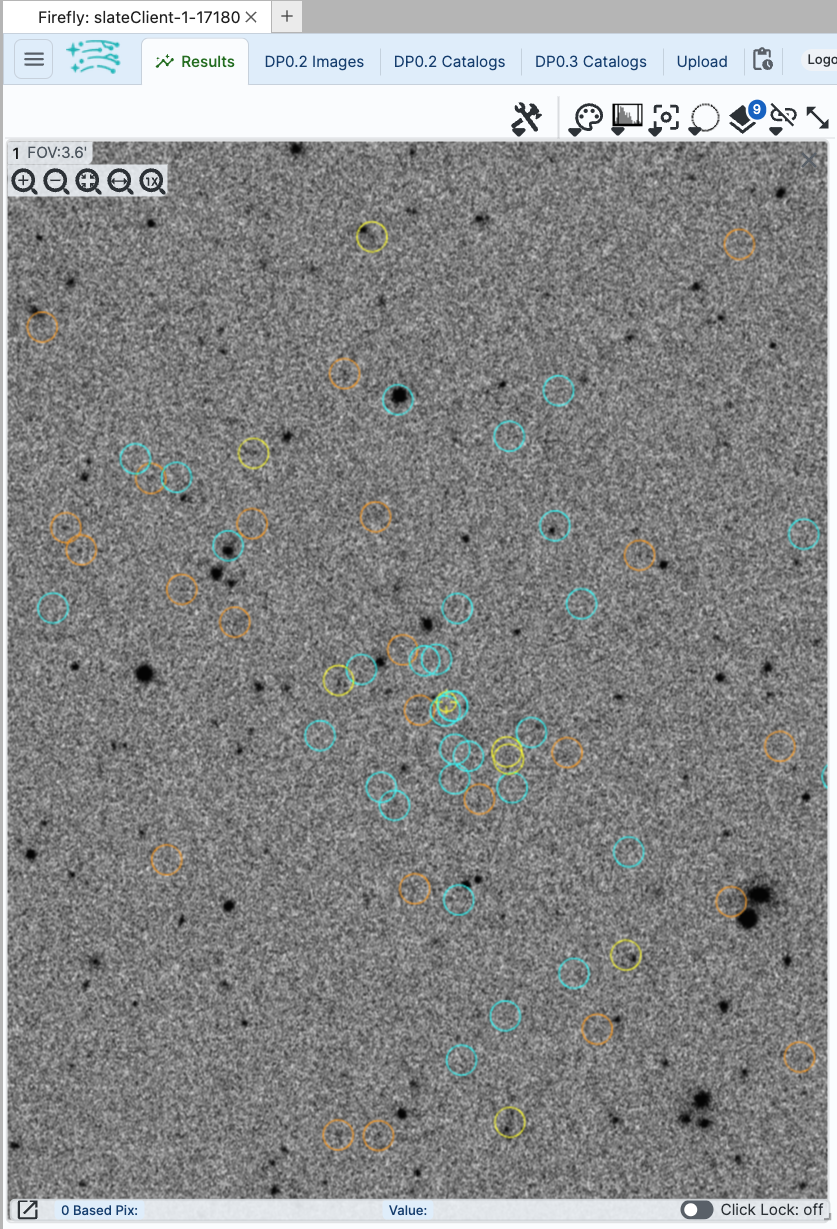

</div>

> Figure 6: A screenshot of the calexp displayed with the locations of forced photometry marked by circles. Coordinates of sub-threshold detections are marked with orange, or yellow if their forced PSF flux was significantly in excess of the deblended flux. Random "off-source" coordinates are marked in cyan.

As a final exploration, plot the histograms of the forced PSF fluxes for the sub-threshold (faint) sources and
the random "off-source" coordinates.

In [ ]:
fig = plt.figure(figsize=(6, 4))
tx1 = np.where(table['type_flag'] == 0)[0]
tx2 = np.where(table['type_flag'] == 1)[0]
plt.hist(table['base_PsfFlux_instFlux'][tx1], bins=10, histtype='step',
         color='darkorange', label='sub-threshold source')
plt.hist(table['base_PsfFlux_instFlux'][tx2], bins=40, histtype='step',
         color='dodgerblue', label='random coordinate')
plt.xlabel('forced PSF flux')
plt.ylabel('number of forced sources')
plt.legend(loc='upper left')
plt.show()

> Figure 7: Above, histograms of the forced PSF flux for random "off-source" coordinates (blue) and for the coordinates of detected sub-threshold sources (orange). As expected, the "off-source" fluxes are centered on zero flux.